# Hopper Puzzle 

<img src="attachment:cover.png" width="700">
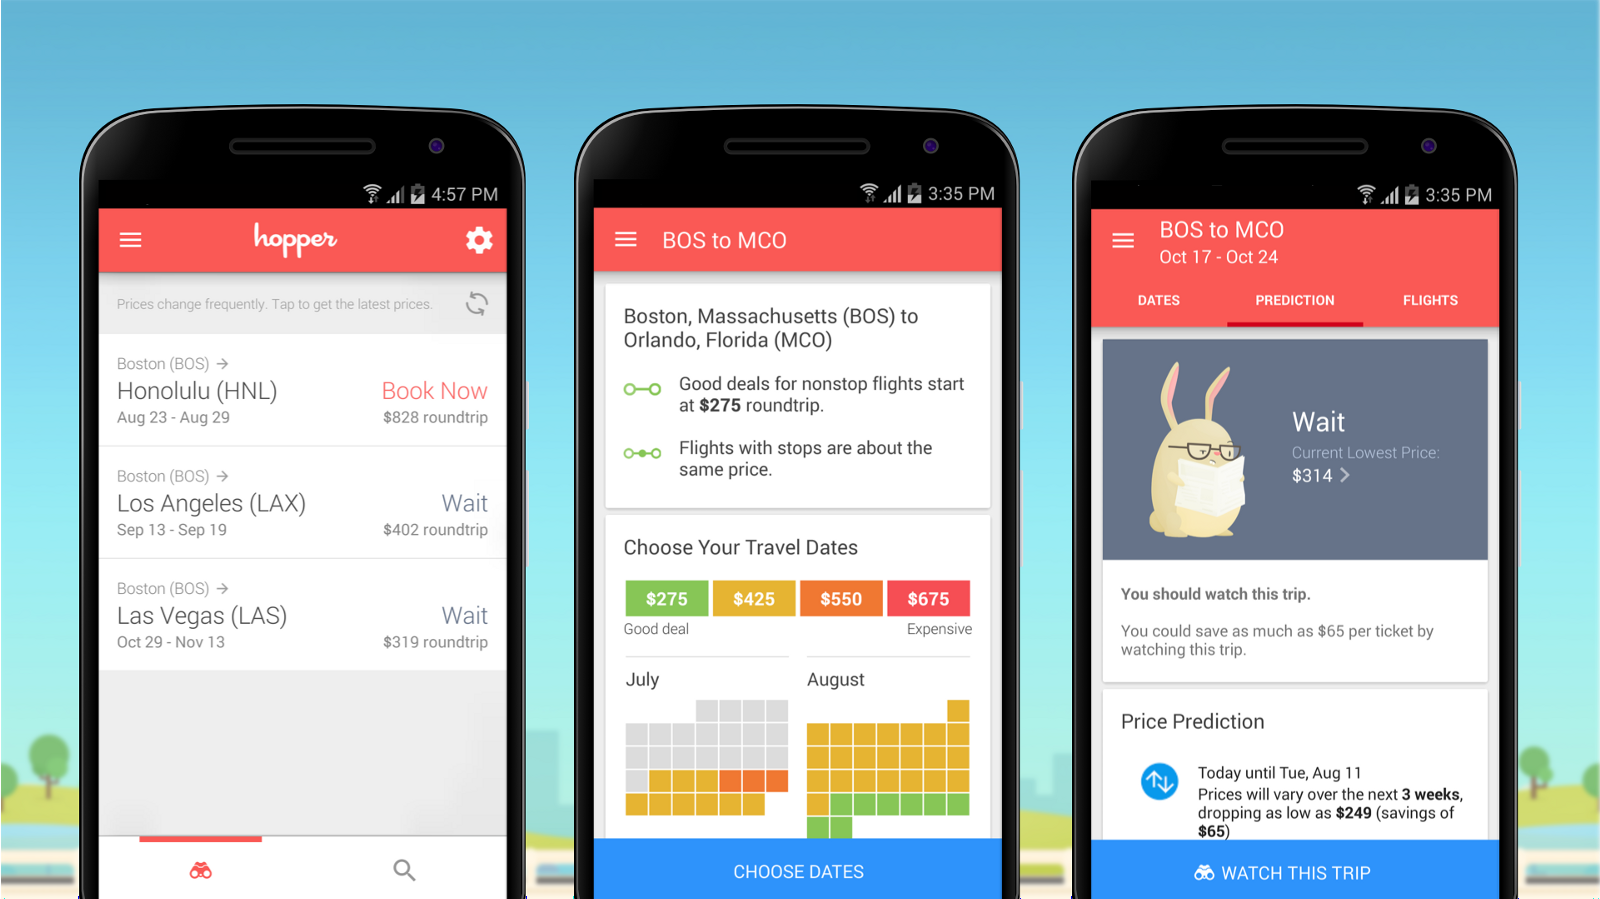

I stumpled upon this data-puzzle provided by Hopper Inc. on their career page for applicants who wish to apply for their Data Scientist position. 

Hopper Inc. is  the maker behind the flight-booking app that predicts the price of flights up to a year in advance with 95 per cent accuracy by using algorithms capable of analyzing massive amounts of data. Depending on the price of tickets when a search is made, Hopper advises users whether they should buy immediately or wait for a better price. The application will then send the user a notification when the flight is at its lowest predicted price.

## Reading the data

In [317]:
import pandas as pd
import numpy as np

In [335]:
df = pd.read_csv('puzzle.csv', header=None)
df.columns = ['col_A','col_B']
df.head(5)

,col_A,col_B
0,0.39715,2.113629
1,0.39715,2.113629
2,0.39715,2.113629
3,0.39715,2.113629
4,0.39715,2.113629


In [319]:
df.describe()

,col_A,col_B
count,1024.000000,1024.000000
mean,0.504729,-0.388165
std,0.355107,1.499346
min,-0.925070,-2.837888
25%,0.389721,-1.559228
50%,0.591392,-1.129903
75%,0.746583,0.578621
max,1.195399,3.096964


The dataset is composed of 2 columns only. Values of col_A range from -.92 to 1.19, col_B range from -2.83 to 3.09. Given that Hopper predicts flight prices based on patterns gleaned from trillions of online flight quotes accumulated from airline booking services spanning several years, my first guess is that these are GPS coordiates or Longitude / Latitude pairs.

Let's generate some scatter plots to validate that hypothesis.

## Exploratory Data Analysis

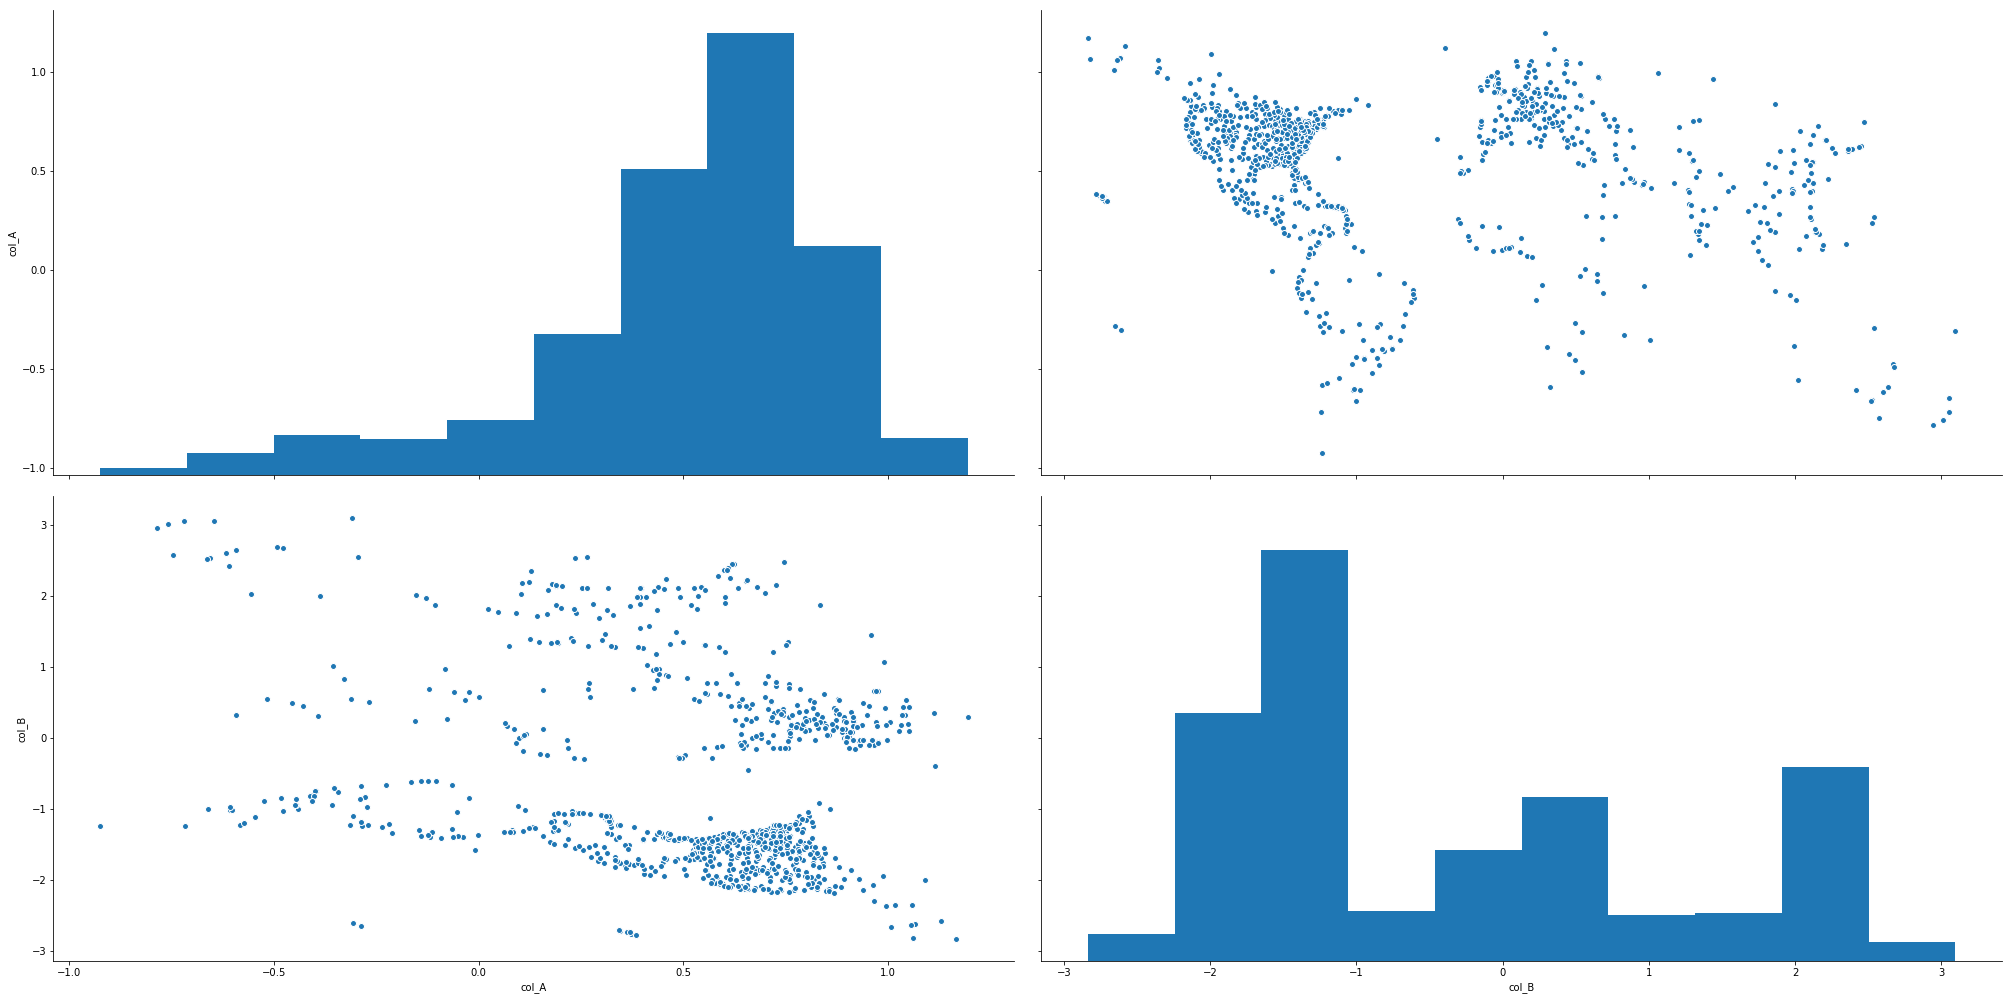

In [5]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline
# Basic correlogram
sns.pairplot(df,size=7, aspect=2)

Is the scatter plot what I think it is? Let's make it bigger!

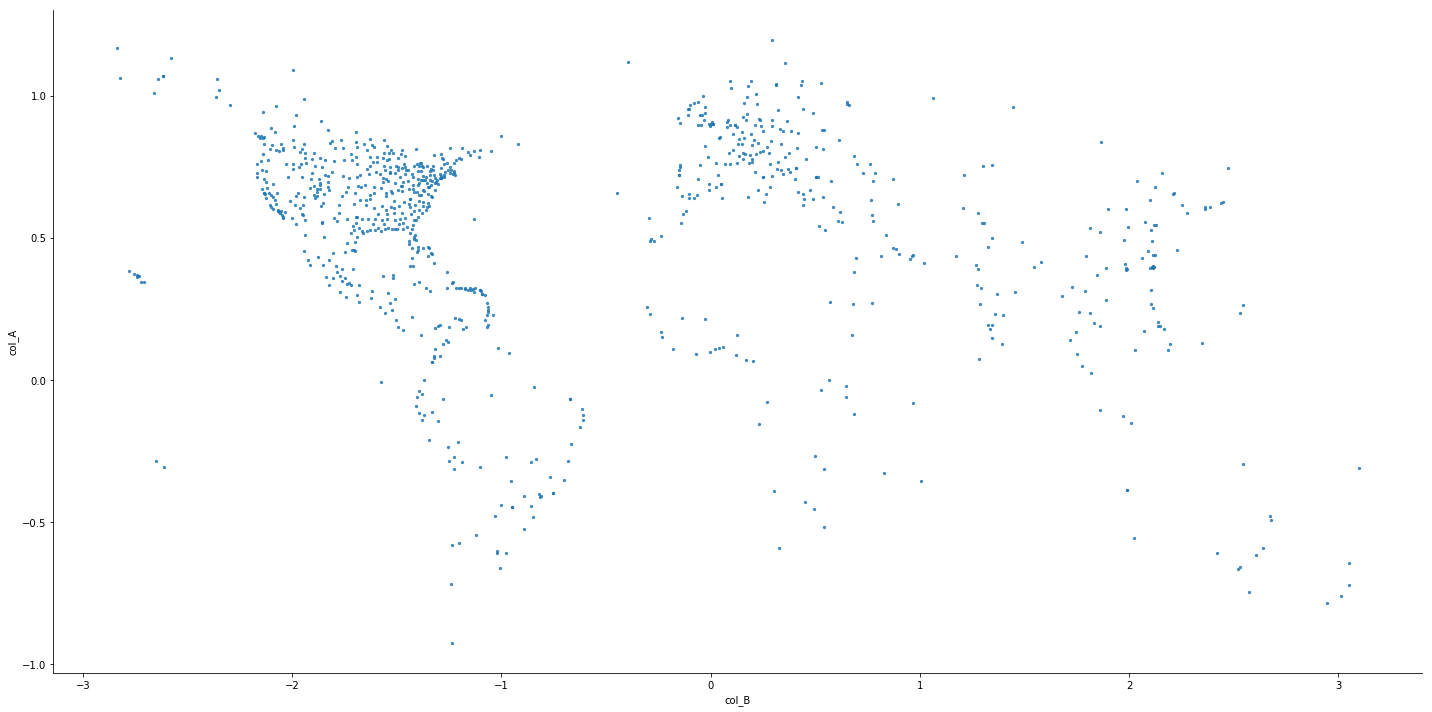

In [6]:
sns.lmplot(x="col_B", y="col_A", data=df,fit_reg=False, size=10, aspect=2, scatter_kws={"s": 5})


This definitely looks like a world map. In order to plot this data on an actual world map with Basemap, we need the data to be in latitude and longtitude format. If I have to take a wild guess, the data is expressed in radian currently. Let's now proceed to convert the values back to latitute and longitude (decimal degree) format.  

In [467]:
import math

#Removing duplicates
df_unique = df.drop_duplicates(subset=['col_A', 'col_B'], keep="first")

#Convert radians to decimal degree
df_unique.col_A = df_unique.col_A*180/math.pi
df_unique.col_B = df_unique.col_B*180/math.pi
df_unique = df_unique.reset_index(drop=True)


/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [353]:
df_unique.head(5)

,col_A,col_B
0,22.755002,121.101998
1,55.437196,-5.686388
2,3.543223,-76.381600
3,41.248103,-8.681388
4,43.512902,43.636603


In [33]:
from mpl_toolkits.basemap import Basemap 

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


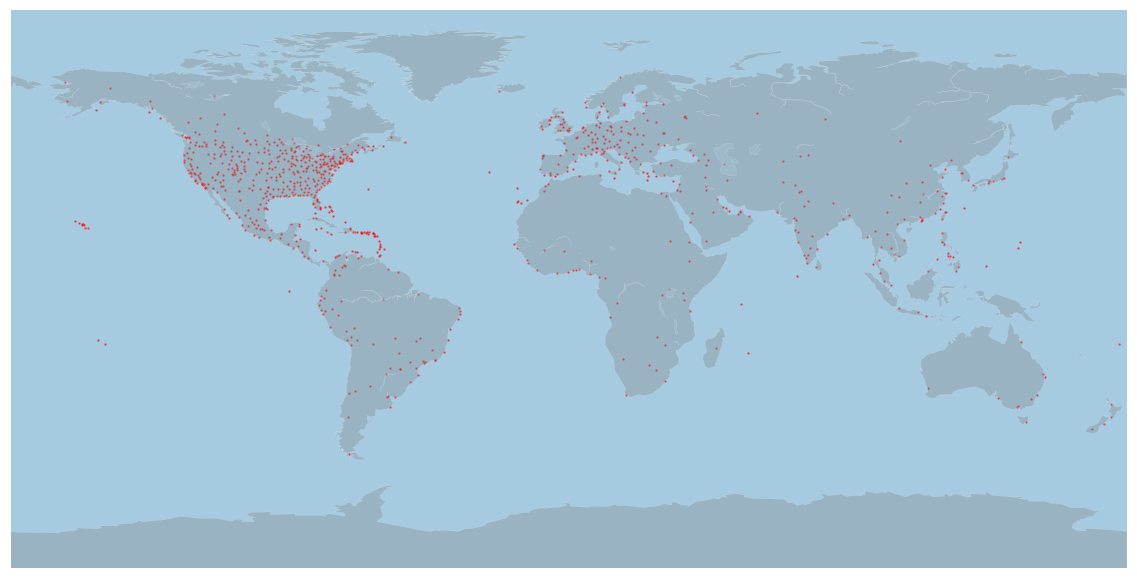

In [34]:

fig, ax = plt.subplots(figsize=(20,20))
earth = Basemap(ax=ax, projection='cyl')
earth.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
earth.fillcontinents(color='grey', alpha=0.3)
earth.drawcoastlines(linewidth=0.1, color="white")

ax.scatter(df_unique['col_B'], df_unique['col_A'],c='red', alpha=0.5, s=2)

Based on the resemblance between the locations of the datapoints and the ones in the [Global Airport Database Map](https://sites.google.com/site/partow/home/global_airport_database_map_large.png), this data is possibly an airport traffic dataset. By doing a quick spot-check with the LAT/LONG pair (43.512902,43.636603), I was able to get a location close to [Nalchik Airport](https://www.latlong.net/c/?lat=43.512902&long=43.636603) in Russia. With a dataset of all airports' coordinates, I should be able to map the LAT/LONG pairs to their nearby airport by computing the shortest distance. 

Having said that, I will use the dataset found at [ourairports.com](http://ourairports.com/data/).

In [382]:
airport_df = pd.read_csv('airports.csv', usecols=['ident','name','latitude_deg','longitude_deg','iso_country'])
airport_df.latitude_deg = airport_df.latitude_deg
airport_df.longitude_deg = airport_df.longitude_deg
airport_df.head(5)

,ident,name,latitude_deg,longitude_deg,iso_country
0,00A,Total Rf Heliport,40.070801,-74.933601,US
1,00AA,Aero B Ranch Airport,38.704022,-101.473911,US
2,00AK,Lowell Field,59.949200,-151.695999,US
3,00AL,Epps Airpark,34.864799,-86.770302,US
4,00AR,Newport Hospital & Clinic Heliport,35.608700,-91.254898,US


In [145]:
len(airport_df)

54363

## Airports Mapping

To calculate the distance between two LAT/LONG pairs, I will need to define the Haversine Formula. What is Haversine Formula?

The **Haversine Formula** determines the **great-circle distance between two points on a sphere given their longitudes and latitudes**. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

In [220]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r



I will now define a function that will determine the closest airport for each of the LAT/LONG pair from Hopper's dataset.

In [250]:
from operator import itemgetter
def closest(airport_data, location_data):  
    dl = []
    for p in range(len(airport_data)):
        ap = {
        'loc_latitude': location_data['col_A'],
        'loc_longitude': location_data['col_B'],
        'nearest_airport': airport_data.ident[p],
        'ap_name': airport_data.name[p],
        'ap_country': airport_data.iso_country[p],
        'ap_latitude': airport_data.latitude_deg[p],
        'ap_longitude': airport_data.longitude_deg[p],
        'distance': haversine(location_data['col_A'],location_data['col_B'],airport_data.latitude_deg[p],airport_data.longitude_deg[p])
        }
        dl.append(ap)
    dl_sorted = sorted(dl, key=lambda k: k['distance'])
    return dl_sorted[0]


This next step requires an extensive run time. So I saved the results as **airports_mapping.csv** file to avoid having to run it again. There must be a quicker way to do this computation, but this is what I came up with at this point. 

In [468]:
#This is the actual airport-mapping step.
#The output is a list of dict which then got converted to a dataframe and saved as airports_mapping.csv 

#airport_mapping=[]
#for m in range(len(df_unique)):
#    airport_mapping.append(closest(airport_df, df_unique.iloc[m]))
#df_airport_mapping = pd.DataFrame(airport_mapping)
#df_airport_mapping.to_csv('airports_mapping.csv', index=False)

In [408]:
#read from the saved airports_mapping.csv from previous step
df_airport_mapping = pd.read_csv('airports_mapping.csv')
df_airport_mapping.loc_latitude = round(df_airport_mapping.loc_latitude,6)
df_airport_mapping.loc_longitude = round(df_airport_mapping.loc_longitude,6)
df_airport_mapping.head(5)

,ap_country,ap_latitude,ap_longitude,ap_name,distance,loc_latitude,loc_longitude,nearest_airport
0,TW,22.754999,121.101997,Taitung Airport,0.000172,22.755002,121.101998,RCFN
1,GB,55.437199,-5.686390,Campbeltown Airport,0.000329,55.437196,-5.686388,EGEC
2,CO,3.543220,-76.381600,Alfonso Bonilla Aragon International Airport,0.000084,3.543223,-76.381600,SKCL
3,PT,41.248100,-8.681390,Francisco de Sá Carneiro Airport,0.000339,41.248103,-8.681388,LPPR
4,RU,43.512901,43.636600,Nalchik Airport,0.000300,43.512902,43.636603,URMN


Now that I have the airports properly mapped, I will left join it to the orginal data (with duplicates) to do further analysis.

In [465]:
df_orig  = df.copy()
df_orig['loc_latitude'] = round(df_orig.col_A*180/math.pi,6)
df_orig['loc_longitude']= round(df_orig.col_B*180/math.pi,6)

In [440]:
df_final = pd.merge(df_orig, df_airport_mapping, how='left', left_on=['loc_latitude', 'loc_longitude'], right_on=['loc_latitude', 'loc_longitude'])
df_final.head(20)

,col_A,col_B,loc_latitude,loc_longitude,ap_country,ap_latitude,ap_longitude,ap_name,distance,nearest_airport
0,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
1,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
2,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
3,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
4,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
5,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
6,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
7,0.397150,2.113629,22.755002,121.101998,TW,22.754999,121.101997,Taitung Airport,0.000172,RCFN
8,0.967562,-0.099246,55.437196,-5.686388,GB,55.437199,-5.686390,Campbeltown Airport,0.000329,EGEC
9,0.061841,-1.333110,3.543223,-76.381600,CO,3.543220,-76.381600,Alfonso Bonilla Aragon International Airport,0.000084,SKCL


Who would've known? Had I kept the latitude/longitude values at 4 decimal places, there would have been no need for the haversine formula to map the airports, at least for the majority of them.

## Further Analysis

Let's start by looking at the distribution by airport.

,index,nearest_airport
0,RCFN,101
1,EGMC,2
2,PANC,2
3,KTRI,2
4,SKCL,2


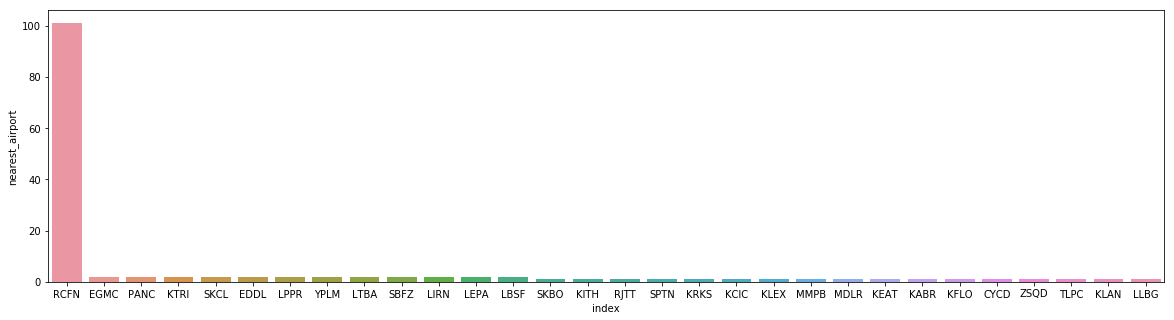

In [464]:
plot_data = pd.DataFrame(df_final['nearest_airport'].value_counts()[:30]).reset_index()
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, x="index", y="nearest_airport", data=plot_data)
plot_data.head(5)

As seen from the above plot of Top 30 airports, RCFN (Taitung Airport in Taiwan) has 101 counts in this dataset while the rest of the airports on has 2 counts or less. If this is an airport traffic dataset, I would have expected to see ATL(Hartsfield–Jackson Atlanta International Airport in Atlanta, Georgia, U.S.). Taitung Airport is not even the busiest airports in Taiwan; so what could this high volume of counts for Taitung Airport be?

,index,ap_country
0,US,0.356794
1,TW,0.101662
2,MX,0.035191
3,CA,0.035191
4,BR,0.025415


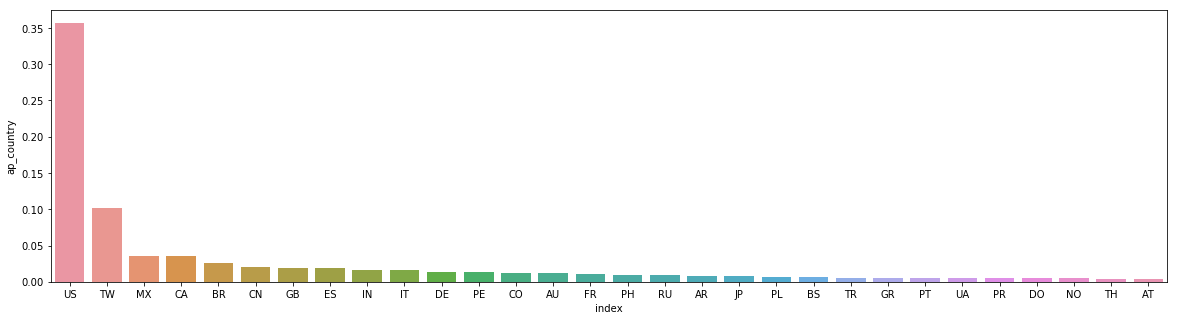

In [462]:
plot_data = pd.DataFrame(df_final['ap_country'].value_counts(normalize=True)[:30]).reset_index()
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, x="index", y="ap_country", data=plot_data)
plot_data.head(5)

If we now look at the distribution by country, US occupies 35.6% of the counts, followed by Taiwan (10.2%), Mexico (3.5%), Canada (3.5%), and Brazil (2.5%).

## Conclusion

I can (somewhat) understand the overall high count of US, but Taiwan having second highest count still baffles me. Taitung Airport alone accounts for 10% of this dataset. Based on these evidences, it is unlikely that this is a dataset on airport traffic. 

Other possible hypotheses of what this dataset could be:
- list of alternate airports for popular destination searches that could save travellers' money 
- list of destinations that Hopper's users are interested in (is it possible that the interest of going to Taiwan increased due to any major event held there when this data was recorded?)
- count of flight disruption warnings (Taiwan has typhoon which occassionally distrupts flights)
